In [1]:
from baseline_cnn import *
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as func
import torch.nn.init as torch_init
import torch.optim as optim

# Data utils and dataloader
import torchvision
from torchvision import transforms, utils
import matplotlib.pyplot as plt

In [2]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [3]:
# Check if your system supports CUDA
use_cuda = torch.cuda.is_available()

# Setup GPU optimization if CUDA is supported
if use_cuda:
    computing_device = torch.device("cuda")
    extras = {"num_workers": 1, "pin_memory": True}
    print("CUDA is supported")
else: # Otherwise, train on the CPU
    computing_device = torch.device("cpu")
    extras = False
    print("CUDA NOT supported")

CUDA NOT supported


## Load Data

In [4]:
transform = transforms.Compose([transforms.Resize(224), transforms.CenterCrop(224), transforms.ToTensor()])
dataset = loader('train.csv','./datasets/cs154-fa19-public/',transform=transform)
batch_size = 64
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

## Show a sample from the dataset

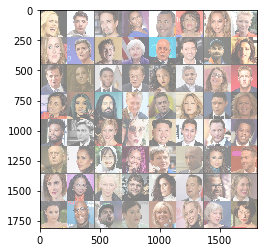

tensor([ 23, 148, 125, 169,  32, 123, 158, 110,  23, 155,  48, 136,  45, 102,
         62, 191, 174,  63,  36, 121, 109, 177,  66, 143,  94,  95, 199, 128,
         61, 109,  71,  25, 175, 163, 192, 189, 130, 111, 117,  10,   6,  86,
         79,  63,  99,  77,   9,  64,  51,   9, 110, 113,  89, 129,  32, 190,
         65,  30,  62,  15,  85,  21, 151,  88])


In [5]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next() # Batch_size is 4, so we get 4 images by calling next

# Places the images in a grid
imshow(torchvision.utils.make_grid(images))
print(labels)

## Create the network

In [6]:
net=Nnet().to(computing_device)
net.apply(weights_init)
print(net)

Nnet(
  (main): Sequential(
    (0): Conv2d(3, 21, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU(inplace)
    (2): Conv2d(21, 20, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace)
    (5): Conv2d(20, 15, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace)
    (8): Conv2d(15, 7, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace)
  )
  (fc): Sequential(
    (0): Linear(in_features=1183, out_features=300, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=300, out_features=201, bias=True)
    (3): Softmax()
  )
)


## Define the Lossfunction and the Optimizer

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001, weight_decay=0.0005) # net.parameters is the weights of the network.


## Train the network

In [8]:
# Track the loss across training
total_loss = []
avg_minibatch_loss = []
N = 50
PATH = "./cnn_celeb.pth" # Where to save the model

for epoch in range(1):
    N_minibatch_loss = 0.0

    # Get the next minibatch of images, labels for training
    for minibatch_count, (images, labels) in enumerate(train_loader, 0):
        print("Mini_batch:", minibatch_count)
        # Zero out the stored gradient (buffer) from the previous iteration
        optimizer.zero_grad()
        # Put the minibatch data in CUDA Tensors and run on the GPU if supported
        images, labels = images.to(computing_device), labels.to(computing_device)
        # Perform the forward pass through the network and compute the loss
        outputs = net(images)
       
        #labels= func.one_hot(labels, num_classes=201).type(torch.FloatTensor)
        loss = criterion(outputs, labels)
        # Automagically compute the gradients and backpropagate the loss through the network
        loss.backward()

        # Update the weights
        optimizer.step()    
        # Add this iteration's loss to the total_loss
        total_loss.append(loss.item())
        N_minibatch_loss += loss
               
        
        if minibatch_count % N == 49:
            #Print the loss averaged over the last N mini-batches
            N_minibatch_loss /= N
            print('Epoch %d, average minibatch %d loss: %.3f' % (epoch + 1, minibatch_count+1, N_minibatch_loss))
            # Add the averaged loss over N minibatches and reset the counter
            avg_minibatch_loss.append(N_minibatch_loss)
            N_minibatch_loss = 0.0

    print("Finished", epoch + 1, "epochs of training")
    print("Saving model...")
    torch.save(net.state_dict(), PATH)
    
    with torch.no_grad():
        # TODO: Implement validation #with torch.no_grad():
        for minibatch_count, (images, labels) in enumerate(validation_loader, 0):
            pass

Mini_batch: 0


c:\users\michaelt\appdata\local\programs\python\python37\lib\site-packages\torch\nn\modules\container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Mini_batch: 1
Mini_batch: 2
Mini_batch: 3
Mini_batch: 4


KeyboardInterrupt: 

## Test the model

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for images, labels in testloader: # Remember they come in batches
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on test images: %d %%' % (
    100 * correct / total))